In [1]:
import numpy as np

from qrisp import QuantumVariable, rz, rzz, gphase
from qrisp.qaoa import QAOAProblem, RX_mixer

In [ ]:
# ----------------------------
# 1) 24h -> 6+6 candidates
# ----------------------------
def select_candidates(price_24, k=6):
    p = np.asarray(price_24, float)
    assert p.shape == (24,)

    C = np.argsort(p)[:k].tolist()  # lowest prices -> charge candidates
    D = np.argsort(-p)[:k].tolist()  # highest prices -> discharge candidates

    # avoid overlap if flat prices
    if set(C) & set(D):
        D2 = []
        for h in np.argsort(-p).tolist():
            if h not in C:
                D2.append(h)
            if len(D2) == k:
                break
        D = D2

    return C, D


# ----------------------------
# 2) Build QUBO matrix Q for 12 bits
# ----------------------------
def build_qubo(price_24, k=6, lambda_E=5000.0):
    """
    Bits: b = [x0..x_{k-1}, y0..y_{k-1}]  (total n=2k)
    Objective (minimize):
      cost = 5*sum_i p_low[i]*x_i - 4*sum_j p_high[j]*y_j
             + lambda_E*(sum_i x_i - sum_j y_j)^2

    Note:
      eta_c*5 = 4 and Dmax = 4  => end SOC=0 <=> #charge == #discharge
    """
    price_24 = np.asarray(price_24, float)
    C_hours, D_hours = select_candidates(price_24, k=k)
    p_low = price_24[C_hours]
    p_high = price_24[D_hours]

    n = 2 * k
    Q = np.zeros((n, n), dtype=float)

    # ---- linear terms as diagonal (x^T Q x contains Q_ii x_i) ----
    # charge bits 0..k-1
    for i in range(k):
        Q[i, i] += 5.0 * p_low[i]
    # discharge bits k..2k-1
    for j in range(k):
        Q[k + j, k + j] += -4.0 * p_high[j]

    # ---- penalty: lambda_E (sum x - sum y)^2 ----
    # Expand:
    #  A = sum x_i, B = sum y_j
    #  (A-B)^2 = A^2 + B^2 - 2AB
    #  A^2 = sum x_i + 2 sum_{i<i'} x_i x_i'
    #  B^2 = sum y_j + 2 sum_{j<j'} y_j y_j'
    #  AB = sum_{i,j} x_i y_j

    # linear from A^2 and B^2
    for i in range(k):
        Q[i, i] += lambda_E
    for j in range(k):
        Q[k + j, k + j] += lambda_E

    # quadratic within charge: +2 lambda_E for each pair
    for i in range(k):
        for ip in range(i + 1, k):
            coeff = 2.0 * lambda_E
            # in symmetric Q: x^T Q x has 2*Qij*x_i*x_j  -> set Qij = coeff/2
            Q[i, ip] += coeff / 2.0
            Q[ip, i] += coeff / 2.0

    # quadratic within discharge: +2 lambda_E for each pair
    for j in range(k):
        for jp in range(j + 1, k):
            coeff = 2.0 * lambda_E
            a = k + j
            b = k + jp
            Q[a, b] += coeff / 2.0
            Q[b, a] += coeff / 2.0

    # cross terms charge-discharge: -2 lambda_E for each pair x_i y_j
    for i in range(k):
        for j in range(k):
            coeff = -2.0 * lambda_E
            a = i
            b = k + j
            Q[a, b] += coeff / 2.0
            Q[b, a] += coeff / 2.0

    meta = {
        "C_hours": C_hours,
        "D_hours": D_hours,
        "p_low": p_low.tolist(),
        "p_high": p_high.tolist(),
    }
    return Q, meta


# ----------------------------
# 3) QUBO cost operator + classical cost function (Qrisp doc style)
# ----------------------------
def create_QUBO_cost_operator(Q):
    # Matches Qrisp tutorial construction (rz/rzz/gphase):contentReference[oaicite:2]{index=2}
    def QUBO_cost_operator(qv, gamma):
        gamma = gamma / np.sqrt(np.linalg.norm(Q) + 1e-12)

        gphase(-gamma / 4 * (np.sum(Q) + np.trace(Q)), qv[0])

        n = len(Q)
        for i in range(n):
            rz(-gamma / 2 * (np.sum(Q[i, :]) + np.sum(Q[:, i])), qv[i])
            for j in range(n):
                if i != j and Q[i, j] != 0:
                    rzz(gamma / 2 * Q[i, j], qv[i], qv[j])

    return QUBO_cost_operator


def create_QUBO_cl_cost_function(Q):
    def cl_cost_function(counts):
        # counts: dict {bitstring: probability or count}
        energy = 0.0
        for meas, w in counts.items():
            x = np.array(list(meas), dtype=int)
            cost = float(x.T @ Q @ x)
            energy += cost * float(w)
        return energy

    return cl_cost_function


# ----------------------------
# 4) Run QAOA
# ----------------------------
def solve_battery_qaoa(
    price_24, k=6, depth=1, shots=5000, max_iter=50, lambda_E=5000.0
):
    Q, meta = build_qubo(price_24, k=k, lambda_E=lambda_E)

    qarg = QuantumVariable(Q.shape[0])  # 12 qubits when k=6

    problem = QAOAProblem(
        cost_operator=create_QUBO_cost_operator(Q),
        mixer=RX_mixer,
        cl_cost_function=create_QUBO_cl_cost_function(Q),
    )

    # run returns a dict of measured bitstrings -> probabilities (or counts depending on backend)
    res = problem.run(
        qarg,
        depth=depth,
        mes_kwargs={"shots": shots},
        max_iter=max_iter,
    )

    # take best bitstring by highest probability, then compute its cost
    best_bitstring = max(res.items(), key=lambda kv: kv[1])[0]
    x = np.array(list(best_bitstring), dtype=int)
    best_cost = float(x.T @ Q @ x)

    return {
        "meta": meta,
        "Q": Q,
        "distribution": res,
        "best_bitstring": best_bitstring,
        "best_cost": best_cost,
    }


if __name__ == "__main__":
    # ---- Replace with your 24 hourly prices ----
    price_24 = [
        88.96,
        83.82,
        83.00,
        82.56,
        82.82,
        86.01,
        103.21,
        133.09,
        113.73,
        70.89,
        34.14,
        19.97,
        16.49,
        13.72,
        18.62,
        33.65,
        63.00,
        110.37,
        125.03,
        147.60,
        151.42,
        130.49,
        102.28,
        91.85,
    ]

    out = solve_battery_qaoa(
        price_24=price_24, k=6, depth=1, shots=3000, max_iter=30, lambda_E=8000.0
    )

    print(
        "Charge candidates (hours 0..23):",
        out["meta"]["C_hours"],
        "prices:",
        out["meta"]["p_low"],
    )
    print(
        "Discharge candidates (hours 0..23):",
        out["meta"]["D_hours"],
        "prices:",
        out["meta"]["p_high"],
    )
    print("Best bitstring (12 bits):", out["best_bitstring"])
    print("Best QUBO cost:", out["best_cost"])

    # decode bits into actions
    k = 6
    bits = np.array(list(out["best_bitstring"]), dtype=int)
    x_bits = bits[:k]
    y_bits = bits[k:]

    ch_hours = [out["meta"]["C_hours"][i] for i in range(k) if x_bits[i] == 1]
    dis_hours = [out["meta"]["D_hours"][j] for j in range(k) if y_bits[j] == 1]

    print("Charge hours:", sorted(ch_hours))
    print("Discharge hours:", sorted(dis_hours))

Charge candidates (hours 0..23): [13, 12, 14, 11, 15, 10] prices: [13.72, 16.49, 18.62, 19.97, 33.65, 34.14]
Discharge candidates (hours 0..23): [20, 19, 7, 21, 18, 8] prices: [151.42, 147.6, 133.09, 130.49, 125.03, 113.73]
Best bitstring (12 bits): 111111111111
Best QUBO cost: -2522.4900000000107
Charge hours: [10, 11, 12, 13, 14, 15]
Discharge hours: [7, 8, 18, 19, 20, 21]


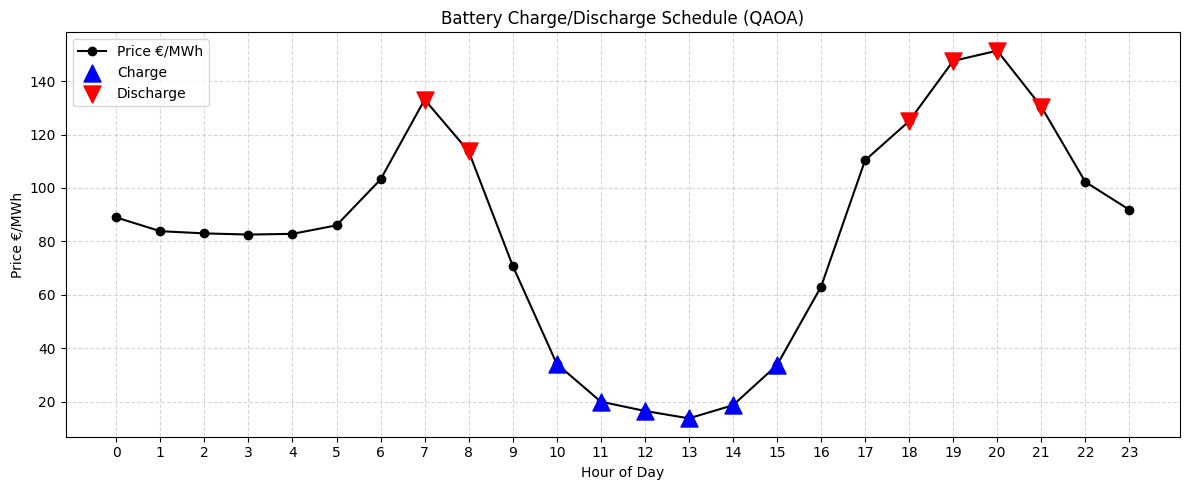

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 24小时价格
# price_24 = [
#     50, 48, 45, 42, 40, 38, 35, 30, 28, 25, 24, 26,
#     35, 50, 65, 80, 90, 85, 70, 60, 55, 52, 51, 50,
# ]

# 从 QAOA 输出中提取
charge_hours = sorted(ch_hours)  # 充电小时列表
discharge_hours = sorted(dis_hours)  # 放电小时列表

hours = np.arange(24)

# 画价格曲线
plt.figure(figsize=(12, 5))
plt.plot(hours, price_24, marker="o", color="black", label="Price €/MWh")

# 标出充电时间
plt.scatter(
    charge_hours,
    [price_24[h] for h in charge_hours],
    color="blue",
    s=150,
    label="Charge",
    zorder=5,
    marker="^",
)

# 标出放电时间
plt.scatter(
    discharge_hours,
    [price_24[h] for h in discharge_hours],
    color="red",
    s=150,
    label="Discharge",
    zorder=5,
    marker="v",
)

plt.xticks(hours)
plt.xlabel("Hour of Day")
plt.ylabel("Price €/MWh")
plt.title("Battery Charge/Discharge Schedule (QAOA)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
